# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

signorm = torch.nn.functional.sigmoid

# sine activation function class
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, x):
        return torch.sin(x)


# cosine activation function class
class Cosine(nn.Module):
    def __init__(self):
        super(Cosine, self).__init__()

    def forward(self, x):
        return torch.cos(x)


# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # self.act = Cosine()
        # self.act = nn.GELU()
        self.act = nn.SiLU()
        # self.act = nn.Tanh()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  # Input layer (time t)
            self.act,         # Activation function
            nn.Linear(50, 50), # Hidden layer
            self.act,         # Activation function
            nn.Linear(50, 1)   # Output layer (displacement x)
        )

    def forward(self, t):
        return self.net(t)

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0

    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*t)
    # sin = torch.sin(phi+w*t)
    exp = torch.exp(-d*t)
    x  = exp*2*A*cos
    return x


# Define the physics-informed loss
def physics_loss(model, mu, k):
    """Defines the physics-informed loss function for the 1D underdamped harmonic oscillator problem."""

    # # t0 is the initial time, tL is the final time, tn are the n time points in between
    t0 = torch.FloatTensor(1,1).fill_(0.0).requires_grad_(True)
    tn = torch.FloatTensor(29,1).uniform_(0, 1).requires_grad_(True)
    # tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1).requires_grad_(True)
    t = torch.concat([t0, tn], dim=0)
    mask = t.squeeze()<=0.5

    # t = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

    # True displacement
    x_true = oscillator(d, w0, t).reshape(-1, 1)
    
    # Predict displacement
    x = model(t)
    
    # Data loss
    dloss = torch.mean((x-x_true)[mask]**2)

    # Automatically compute derivatives
    x_t = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
    x_tt = torch.autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
    
    # differential operator constraint may influence generalization
    
    # Compute the residual of the differential equation
    phy = x_tt + mu*x_t + k*x # = 0
    ploss = torch.mean(phy**2)

    ic1 = torch.mean((x[0]-1.)**2)
    ic2 = torch.mean((x_t[0]-0.)**2)
    ic = ic1 + ic2

    

    # Return the mean squared error against the expected zero
    return (ploss, # physics loss
            dloss, # data loss
            ic) # initial condition loss


# Initialize model, optimizer, and training parameters
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

d, w0 = 2, 20
mu, k = 2*d, w0**2


/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([500, 1]) torch.Size([500, 1])


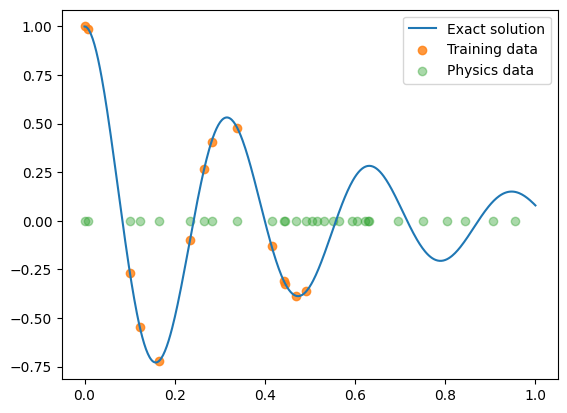

In [2]:
# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(torch.Tensor([d]), torch.Tensor([w0]), x).view(-1,1)
print(x.shape, y.shape)

# # slice out a small number of points from the LHS of the domain
# x_data = x[0:250:20].squeeze()
# y_data = y[0:250:20].squeeze()


# x_physics = torch.linspace(0,1,30).view(-1,1) # sample locations over the problem domain
# t0 is the initial time, tL is the final time, tn are the n time points in between
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(29, 1).uniform_(0, 1)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
x_physics = torch.concat([t0, tn]).squeeze()
y_physics = oscillator(torch.Tensor([d]), torch.Tensor([w0]), x_physics).squeeze()

mask = x_physics <= .5


plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_physics[mask], y_physics[mask], color="tab:orange", alpha=0.8, label="Training data")
plt.scatter(x_physics, 0*x_physics, color="tab:green", alpha=0.4, label="Physics data")
plt.legend()
plt.show()

In [3]:
d, w0 = torch.Tensor([d]), torch.Tensor([w0])
mu, k = torch.Tensor([mu]), torch.Tensor([k])

plosses = []
dlosses = []

# list to track moving average of loss
losses = []  # moving average of loss

# Training loop
for epoch in range(100000):
    optimizer.zero_grad()

    ploss, dloss, icloss = physics_loss(model, mu, k)
    ploss *= 1e-4
    # loss = ploss + dloss + icloss
    loss = dloss
    loss.backward()
    optimizer.step()

    # calculate moving average of loss
    if len(losses) < 100:
        losses.append(loss.item())
    else:
        losses.pop(0)
        losses.append(loss.item())
    
    # check if loss has converged
    std = np.std(losses)
    mean = np.mean(losses)
    if len(losses) == 100 and std < 5e-6 and epoch > 1000 and loss.item() < 1e-5:
        print(f'Converged at epoch {epoch}')
        break
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch},\
        Loss: {mean:.3e},\
        Physics Loss: {ploss.item():.3e},\
        Data Loss: {dloss.item():.3e},\
        IC Loss: {icloss.item():.3e},\
        Loss Std: {std:.3e}')
        scheduler.step()
    
    plosses.append(ploss.item())
    dlosses.append(dloss.item())

Epoch 0,        Loss: 2.908e-01,        Physics Loss: 1.370e-01,        Data Loss: 2.908e-01,        IC Loss: 1.211e+00,        Loss Std: 0.000e+00
Epoch 100,        Loss: 2.639e-01,        Physics Loss: 8.525e-01,        Data Loss: 3.662e-01,        IC Loss: 1.018e+00,        Loss Std: 5.805e-02
Epoch 200,        Loss: 2.365e-01,        Physics Loss: 2.636e+00,        Data Loss: 2.290e-01,        IC Loss: 1.739e+00,        Loss Std: 6.026e-02
Epoch 300,        Loss: 2.451e-01,        Physics Loss: 3.657e+00,        Data Loss: 2.254e-01,        IC Loss: 1.925e+00,        Loss Std: 6.446e-02
Epoch 400,        Loss: 2.468e-01,        Physics Loss: 2.330e+00,        Data Loss: 2.011e-01,        IC Loss: 2.141e+00,        Loss Std: 6.416e-02
Epoch 500,        Loss: 2.309e-01,        Physics Loss: 2.623e+00,        Data Loss: 1.643e-01,        IC Loss: 2.370e+00,        Loss Std: 5.506e-02
Epoch 600,        Loss: 2.371e-01,        Physics Loss: 2.604e+00,        Data Loss: 1.562e-01,       

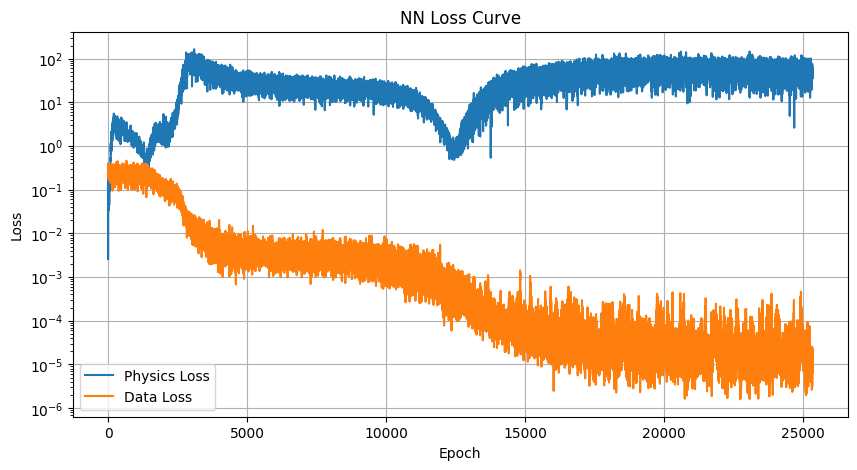

In [4]:
# plot log loss curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(plosses, label='Physics Loss')
ax.plot(dlosses, label='Data Loss')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


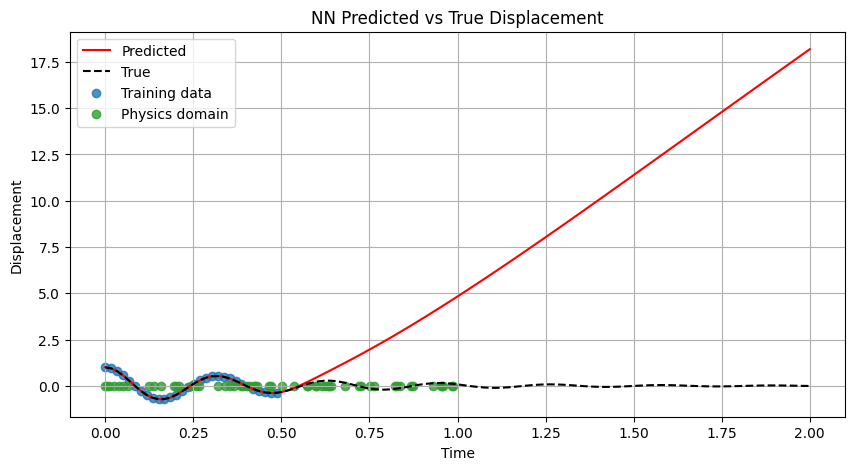

In [5]:
#plot predicted vs true displacement
model.eval()
td = torch.linspace(0, 2, 120).reshape(-1, 1).requires_grad_(True)
t0 = torch.FloatTensor(1).fill_(0.0).reshape(-1, 1)
tn = torch.FloatTensor(119, 1).uniform_(0, 2)
# tL = torch.FloatTensor(1).fill_(2.0).reshape(-1, 1)
tp = torch.concat([t0, tn])
x = model(td).squeeze().detach().numpy()
x_true = oscillator(d, w0, td).squeeze().detach().numpy()

td = td.squeeze().detach().numpy()
data_domain_mask = td<=0.5
physics_domain_mask = tp<=1.0



fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(td, x, color="red", label='Predicted')
ax.plot(td, x_true, color="black", linestyle='--', label='True')
plt.scatter(td[data_domain_mask], x_true[data_domain_mask], color="tab:blue", alpha=0.8, label="Training data")
plt.scatter(tp[physics_domain_mask], 0*tp[physics_domain_mask], color="tab:green", alpha=0.8, label="Physics domain")
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('NN Predicted vs True Displacement')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
#plot predicted vs true velocity
x_t = torch.autograd.grad(x,t, torch.ones_like(x), create_graph=True)[0]  # dx/dt
x_t_true = torch.autograd.grad(x_true,t, torch.ones_like(x_true), create_graph=True)[0]  # dx/dt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_t.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_t_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('PINN Predicted vs True Velocity')
plt.legend()
plt.grid(True)

plt.show()

#plot predicted vs true acceleration
x_tt = torch.autograd.grad(x_t,t, torch.ones_like(x_t), create_graph=True)[0]  # d^2x/dt^2
x_tt_true = torch.autograd.grad(x_t_true,t, torch.ones_like(x_t_true), create_graph=True)[0]  # d^2x/dt^2

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t.detach().numpy(), x_tt.detach().numpy(), label='Predicted')
ax.plot(t.detach().numpy(), x_tt_true.detach().numpy(), label='True')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('PINN Predicted vs True Acceleration')
plt.legend()
plt.grid(True)

plt.show()
